# Navigation
---

This notebook contains a training solution for a Reinforcement Learning project, in which an actor has to collect specific objects (yellow bananas) while avoiding others (blue bananas) in a closed space.


In [1]:
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import torch

In [2]:
# Linux x86_64
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64", no_graphics=True, worker_id=1, seed=1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity environments contain brains, which encapsulate the decision making process. Every agent must be assigned a brain (and more than one agent can use the same brain). From [this link](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Design-Brains.md), there are three kind of brains: learning, heuristic and player.

To solve this project, we use de default brain.

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Exploring the environment

In [4]:
env_info = env.reset(train_mode=True)[brain_name]

num_actions = brain.vector_action_space_size
num_states = len(env_info.vector_observations[0])

print('Number of agents: {}'.format(len(env_info.agents)))
print('Number of actions: {}'.format(num_actions))
print('Number of dimension of the state: {}'.format(num_states))

Number of agents: 1
Number of actions: 4
Number of dimension of the state: 37


## Training an agent

In [5]:
from Agent import Agent
from collections import deque
from DQN import DQN
from ReplayBuffer import ReplayBuffer
from typing import List

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def train(agent: Agent, env: UnityEnvironment, n_episodes: int, max_t: int, filename_pth: str, eps_start=1.0, eps_end=0.01, eps_decay=0.995) -> List[int]:
    """
    Trains an agent.
    
    Params:
        agent: agent to be trained.
        n_episodes: number of episodes we use to train the agent.
        filename_pth: path where the weights of the network are stored.
    Returns:
        A List with all scores obtained during training.
    """
    all_scores = []
    # We need to keep the last 100 scores to finish when avg(last_scores) >= 13.
    last_scores = deque(maxlen=100)
    eps = eps_start
    
    for i in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(0, max_t):
            action = agent.next_action(state, eps)
            env_info = env.step(action.item())[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.train(state, action, reward, next_state, done)
            score += reward
            
            if done:
                break
            
            state = next_state
            
        last_scores.append(score)
        all_scores.append(score)
        mean_last_scores = np.mean(last_scores)
        eps = max(eps_end, eps_decay*eps)
        
        if i % 50 == 0:
            print('Episode {} with score: {:.2f}'.format(i, mean_last_scores.item()))
            sys.stdout.flush()
                
        if mean_last_scores >= 13:
            print("Solved in {} episodes with score {:.2f}".format(i, mean_last_scores.item()))
            agent.save_nn(filename_pth)
            break
    return all_scores

In [8]:
rb = ReplayBuffer(10000, seed=13)
model = DQN(num_states, num_actions).to(device)
batch_size = 64
samples_to_train = 4

# default gamma=0.95
agent = Agent(model, rb, num_actions, batch_size, samples_to_train, device)

In [9]:
import time

n_episodes = 5000
max_t = 1000
filename_weights = 'tmp.pth'
start_time = time.time()
scores = train(agent, env, n_episodes, max_t, filename_weights)
print("{} seconds".format(time.time() - start_time))

Episode 50 with score: 0.42
Episode 100 with score: 0.19
Episode 150 with score: 1.13
Episode 200 with score: 3.09
Episode 250 with score: 5.27
Episode 300 with score: 6.97
Episode 350 with score: 8.08
Episode 400 with score: 9.39
Episode 450 with score: 11.08
Episode 500 with score: 12.49
Episode 550 with score: 12.74
Episode 600 with score: 12.03
Episode 650 with score: 12.77
Solved in 654 episodes with score 13.02
872.2634034156799 seconds


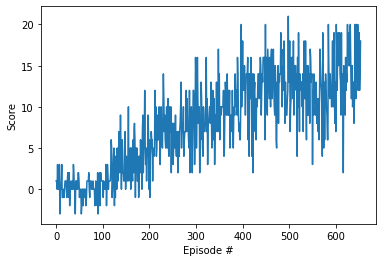

In [10]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()